<a href="https://colab.research.google.com/github/mailazorzan/trees/blob/main/Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trees

#### Nos baseamos em um código já existente, disponibilizado no link abaixo, e então fizemos algumas modificações: refatoramos as funções, retornamos as probabilidades, encapsulamos o modelo em uma classe Decision Tree e também implementamos uma classe de Bagging Trees.



### versão modificada **v4**

código original disponível em https://github.com/SebastianMantey/Decision-Tree-from-Scratch

* **v0**: código original
* **v1**: funções refatoradas
* **v2**: retorna probabilidades
* **v3**: encapsula o modelo numa classe - Decision Tree
* **v4**: implementação da classe Bagging Trees

The goal of this notebook is to code a decision tree classifier that can be used with the following API.

# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Load and Prepare Data

#### Format of the data
- last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [2]:

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
df = pd.read_csv(url, names=names)

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [41]:
df.loc[129]

sepal_length               7.2
sepal_width                  3
petal_length               5.8
petal_width                1.6
label           Iris-virginica
Name: 129, dtype: object

In [19]:
# Garantindo que não temos nulos no conjunto...
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
label           0
dtype: int64

In [20]:
# Garantindo que não temos NAs no conjunto...
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
label           0
dtype: int64

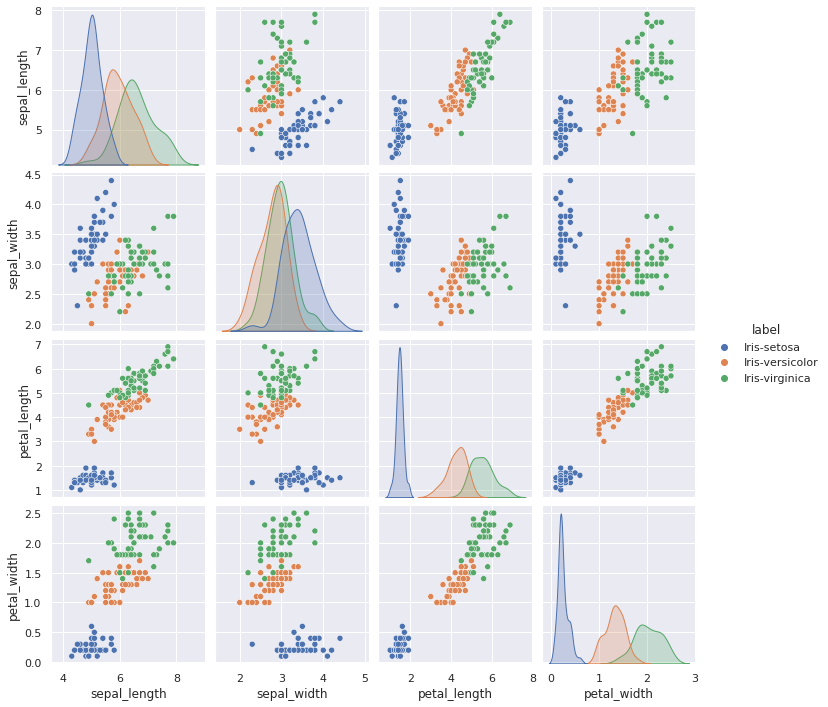

In [4]:
import seaborn as sns; sns.set()
sns.pairplot(data = df, hue = 'label')

# Train-Test-Split

In [6]:
from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(df, test_size = 20, random_state = 100)

In [7]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

random.seed(0)
train_df, test_df = train_test_split(df, test_size=20)

# Helper Functions

In [8]:
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

## Classe Decision Tree

In [9]:
class DecisionTree(object):
    """
    """
    def __init__(self, max_depth = 3, min_samples = 2, x=0, y=1, z=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        
    # TREINAMENTO.....
    def _check_purity(self, data):
        """ helper """
        label_column = data[:, -1]
        qty_unique_classes = len(np.unique(label_column))

        return not (qty_unique_classes - 1)
    
    def _classify_data(self, data):
        """ helper """
        label_column = data[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

        prevalent_class_index = counts_unique_classes.argmax()
        classification = unique_classes[prevalent_class_index]

        return unique_classes, counts_unique_classes
    
    def _get_potential_splits(self, data):
        """ helper """
        potential_splits = {}
        _, n_columns = data.shape

        rolling_mean = lambda a: ((a[1:] + a[:-1])/2).tolist()

        for column_index in range(n_columns - 1):        # excluding the last column which is the label
            values = data[:, column_index]
            unique_values = np.unique(values)

            potential_splits[column_index] = rolling_mean(unique_values)

        return potential_splits
    
    def _split_data(self, data, split_column, split_value):
        """ helper """
        split_column_values = data[:, split_column]

        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]

        return data_below, data_above
    
    def _calculate_entropy(self, data):
        """ helper """
        label_column = data[:, -1]
        _, counts = np.unique(label_column, return_counts=True) # note que np.unique so retorna labels encontrados...

        probabilities = counts / counts.sum()
        entropy = - probabilities @ np.log2(probabilities) # ... assim não vai existir 0 * inf, o que no lim daria 0 mesmo

        return entropy
    
    def _calculate_overall_entropy(self, data_below, data_above):
        """ helper """
        lens_ba = np.array([len(data_below), len(data_above)])
        probs_ba = lens_ba / lens_ba.sum()

        entropy_ba = np.array([self._calculate_entropy(data_below), 
                               self._calculate_entropy(data_above)])

        overall_entropy =  probs_ba @ entropy_ba

        return overall_entropy
    
    def _determine_best_split(self, data, potential_splits):
        """ helper """
        overall_entropy = 9999
        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                data_below, data_above = self._split_data(data, 
                                                          split_column=column_index, 
                                                          split_value=value)
                current_overall_entropy = self._calculate_overall_entropy(data_below, 
                                                                          data_above)
                if current_overall_entropy <= overall_entropy:
                    overall_entropy = current_overall_entropy
                    best_split_column = column_index
                    best_split_value = value

        return best_split_column, best_split_value
    
    def _stop_split(self, data, counter):
        """
        helper. O nó deve parar de ser dividido?
        incluir todas as condições para parar de dividir o nó
        returns
        -------
        stop_split:
            True: se o nó for terminal, i.e., uma das condições de parada foi atingido
            False: se o nó for intermediário, pode ir seguir quebrando
        """
        stop_split = self._check_purity(data) or (len(data) < self.min_samples) or \
                    (counter == self.max_depth)
        return stop_split
    
    def fit(self, df):
        """
        função externa para montar a arvore
        """
        self.tree_ = self._decision_tree_algorithm(df)
    
    def _decision_tree_algorithm(self, df, counter = 0):
        """
        procedimento recursivo para montar a arvore
        """
    
        # data preparations
        if counter == 0:
            #global COLUMN_HEADERS
            self.column_headers = df.columns
            data = df.values
        else:
            data = df           

        # base cases
                
        basecase_reached = self._stop_split(data, counter)   
        if basecase_reached:
            classification, counts_unique_classes = self._classify_data(data)
            return classification, counts_unique_classes

        # recursive part
        else:    
            counter += 1

            # helper functions 
            potential_splits = self._get_potential_splits(data)
            split_column, split_value = self._determine_best_split(data, potential_splits)
            data_below, data_above = self._split_data(data, split_column, split_value)

            # instantiate sub-tree
            feature_name = self.column_headers[split_column]
            question = "{} <= {}".format(feature_name, split_value)
            sub_tree = {question: []}

            # find answers (recursion)
            yes_answer = self._decision_tree_algorithm(data_below, counter)
            no_answer  = self._decision_tree_algorithm(data_above, counter)

            # If the answers are the same, then there is no point in asking the qestion.
            # This could happen when the data is classified even though it is not pure
            # yet (min_samples or max_depth base case).
            if np.array_equal(yes_answer, no_answer):
                sub_tree = yes_answer
            else:
                sub_tree[question].append(yes_answer)
                sub_tree[question].append(no_answer)

            return sub_tree
    
    # PREDICOES.....
    def predict(self, df):
        """
        função externa para predição. 
        percorre a arvore em busca de um nó terminal
        """
        prediction = df.apply(self._classify_example, axis = 1)
        prediction = prediction.apply(pd.Series)
        prediction.columns = ['pred', 'proba']
        
        return prediction
    
    def _calc_probs(self, a):
        """ helper, retorna vetor normalizado por L1"""
        norm = a[1].sum()
        res = {k: v/norm for k, v in zip(a[0], a[1])}
        return res

    def _get_most_prevalent_class(self, a):
        """ helper, retorna a classe mais prevalente"""
        most_prevalent_idx = a[1].argmax()
        most_prevalent_class = a[0][most_prevalent_idx]
        return most_prevalent_class
    
    def _classify_example(self, example, tree = None):
        """ proc recursivo que retorna a classificação e as probabilidades
        """
        
        if not tree:  # prim. chamada, usar arvore inteira
            tree = self.tree_
        
        question = list(tree.keys())[0]
        feature_name, comparison_operator, value = question.split(" ")

        # ask question
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

        # base case
        if not isinstance(answer, dict):
            probs = self._calc_probs(answer)
            the_class = self._get_most_prevalent_class(answer)
            return the_class, probs

        # recursive part
        else:
            residual_tree = answer
            return self._classify_example(example, residual_tree)
    

# Classe Bagging Trees

In [10]:
class BaggingTrees(object):

    def __init__(self, n_estimators = 10, **tree_params):
        """
        # Construtor
        """
        self._n_estimators = n_estimators
        self._tree_params = tree_params
        self._estimators = [DecisionTree(**tree_params) for _ in range (self._n_estimators)]


    def samples_bootstrap(self, df):
        """
        # Gera as amostras, no caso, um df com 10 amostras aleatórias.
        """
        df_bags = pd.DataFrame(columns = df.columns)
        ind = df.index.tolist()
        for amostra in range(len(df)):
            sample = random.sample(population=ind, k=1)
            df_bags = df_bags.append(df.loc[sample])
        
        return(df_bags)
        
        
    def fit(self, df):
        """
        função para treinar os diversos estimadores
        """
        lstbags = []
        for _ in range(self._n_estimators):
            lstbags.append(self.samples_bootstrap(df))
            
        for j in range(self._n_estimators):
            self._estimators[j].fit(lstbags[j])     
             
         
                
    def predict(self, df):
        """
        função externa para predição, retorna a média das probabilidades e a classe com a maior probabilidade
        """        
        predc = []
        for i in range(self._n_estimators):
            predc.append(self._estimators[i].predict(df)['proba'].apply(pd.Series).fillna(0)) # predict da Decision Tree
        
        m_probabilidades = pd.concat(predc).groupby(level=0).mean()
        m_probabilidades['pred'] = m_probabilidades.columns[m_probabilidades.values.argmax(axis=1)]
        
        return m_probabilidades               

# Testes

### Decision Tree

In [21]:
dt = DecisionTree(max_depth = 3, min_samples = 5)
dt.fit(train_df)
preds_dt = dt.predict(test_df)

In [39]:
preds_dt.loc[129]

pred                                        Iris-virginica
proba    {'Iris-versicolor': 0.25, 'Iris-virginica': 0.75}
Name: 129, dtype: object

### Bagging Trees

In [28]:
bt = BaggingTrees(n_estimators=10, max_depth=3, min_samples=5)

bt.fit(train_df)

predicoes = bt.predict(test_df.iloc[:, :-1])

In [38]:
predicoes.loc[129]

Iris-versicolor          0.178571
Iris-virginica           0.821429
Iris-setosa                     0
pred               Iris-virginica
Name: 129, dtype: object

### Segunda versão do Decision Tree

In [13]:
dt = DecisionTree(max_depth = 2, min_samples = 15)
dt.fit(train_df)

pprint(dt.tree_)

{'petal_width <= 0.8': [(array(['Iris-setosa'], dtype=object), array([46])),
                        {'petal_width <= 1.65': [(array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
                                                  array([41,  3])),
                                                 (array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
                                                  array([ 1, 39]))]}]}


In [16]:
s = test_df.iloc[:, : -1]
preds = dt.predict(s)

In [40]:
preds.loc[129]

pred                                       Iris-versicolor
proba    {'Iris-versicolor': 0.9318181818181818, 'Iris-...
Name: 129, dtype: object